
# Loading in the Data
In this example, we are going to use crossed columns and embedding columns inside of a tensorflow object created with keras.

However, we will start the process by loading up a dataset with a mix of categorical data and numeric data. This dataset is quite old and has been used many times in machine learning examples: the census data from 1990's. We will use it to predict if a person will earn over or under 50k per year.

- https://archive.ics.uci.edu/ml/datasets/Census-Income+(KDD)
- This data goes by various name, including the "Adult" dataset and 1996 census data

In [1]:
import pandas as pd

headers = ['age','workclass','fnlwgt','education','edu_num','marital_status',
           'occupation','relationship','race','sex','cap_gain','cap_loss','work_hrs_weekly','country','income']
df_train_orig = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',names=headers)
df_test_orig = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',names=headers)
df_test_orig = df_test_orig.iloc[1:]
print(df_train_orig.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              32561 non-null  int64 
 1   workclass        32561 non-null  object
 2   fnlwgt           32561 non-null  int64 
 3   education        32561 non-null  object
 4   edu_num          32561 non-null  int64 
 5   marital_status   32561 non-null  object
 6   occupation       32561 non-null  object
 7   relationship     32561 non-null  object
 8   race             32561 non-null  object
 9   sex              32561 non-null  object
 10  cap_gain         32561 non-null  int64 
 11  cap_loss         32561 non-null  int64 
 12  work_hrs_weekly  32561 non-null  int64 
 13  country          32561 non-null  object
 14  income           32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None


In [2]:
from copy import deepcopy
df_train = deepcopy(df_train_orig)
df_test = deepcopy(df_test_orig)

The data is organized as follows: 

|Variable | description|
|----|--------|
|age: | continuous|
|workclass:      |Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, ...|
|fnlwgt:         |continuous.|
|education:      |Bachelors, Some-college, 11th, HS-grad, Prof-school, ...|
|education-num:  |continuous.|
|marital-status: |Married-civ-spouse, Divorced, Never-married, Separated, Widowed, ... |
|occupation:     |Tech-support, Craft-repair, Other-service, ...|
|relationship:   | Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.|
|race:           |White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.|
|sex:            |Female, Male.|
|capital-gain:   |continuous.|
|capital-loss:   |continuous.|
|hours-per-week: |continuous.|
|native-country: |United-States, Cambodia, England, ... |
|**income (target):**|<50k, >=50k| 

In [3]:
import numpy as np

# let's just get rid of rows with any missing data
# and then reset the indices of the dataframe so it corresponds to row number
df_train.replace(to_replace=' ?',value=np.nan, inplace=True)
df_train.dropna(inplace=True)
df_train.reset_index()

df_test.replace(to_replace=' ?',value=np.nan, inplace=True)
df_test.dropna(inplace=True)
df_test.reset_index()

df_test.head()

,age,workclass,fnlwgt,education,edu_num,marital_status,occupation,relationship,race,sex,cap_gain,cap_loss,work_hrs_weekly,country,income
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
6,34,Private,198693.0,10th,6.0,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30.0,United-States,<=50K.


## Processing
For preprocessing, we are going to fix a few issues in the dataset. 

- This first includes the use of "50K." instead of "50K" in the test set. 
- Next, we will encode the categorical features as integers (eventually we will deal with these integers like a one-hot encoding)
- Finally, we will make certain all the continuous data is scaled properly with zero mean and unit standard deviaiton

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# replace strings
if df_test.income.dtype=='object':
    df_test.income.replace(to_replace=[' <=50K.',' >50K.'],value=['<=50K','>50K'],inplace=True)
    print(df_test.income.value_counts())

# define objects that can encode each variable as integer    
encoders = dict() 
categorical_headers = ['workclass','education','marital_status',
                       'occupation','relationship','race','sex','country']

# train all encoders (special case the target 'income')
for col in categorical_headers+['income']:
    df_train[col] = df_train[col].str.strip()
    df_test[col] = df_test[col].str.strip()
    
    if col=="income":
        tmp = LabelEncoder()
        df_train[col] = tmp.fit_transform(df_train[col])
        df_test[col] = tmp.transform(df_test[col])
    else:
        # integer encoded variables
        encoders[col] = LabelEncoder() # save the encoder
        df_train[col+'_int'] = encoders[col].fit_transform(df_train[col])
        df_test[col+'_int'] = encoders[col].transform(df_test[col])

# scale the numeric, continuous variables
numeric_headers = ["age", "cap_gain", "cap_loss","work_hrs_weekly"]

for col in numeric_headers:
    df_train[col] = df_train[col].astype(np.float)
    df_test[col] = df_test[col].astype(np.float)
    
    ss = StandardScaler()
    df_train[col] = ss.fit_transform(df_train[col].values.reshape(-1, 1))
    df_test[col] = ss.transform(df_test[col].values.reshape(-1, 1))
    
df_test.head()

<=50K    11360
>50K      3700
Name: income, dtype: int64


,age,workclass,fnlwgt,education,edu_num,marital_status,occupation,relationship,race,sex,...,country,income,workclass_int,education_int,marital_status_int,occupation_int,relationship_int,race_int,sex_int,country_int
1,-1.023104,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,...,United-States,0,2,1,4,6,3,2,1,38
2,-0.033340,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,...,United-States,0,2,11,2,4,0,4,1,38
3,-0.794697,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,...,United-States,1,1,7,2,10,0,4,1,38
4,0.423474,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,...,United-States,1,2,15,2,6,0,2,1,38
6,-0.337883,Private,198693.0,10th,6.0,Never-married,Other-service,Not-in-family,White,Male,...,United-States,0,2,0,4,7,1,4,1,38


In [5]:
# let's start as simply as possible, without any feature preprocessing
categorical_headers_ints = [x+'_int' for x in categorical_headers]

# we will forego one-hot encoding right now and instead just use all inputs as-is
#   this is just to get an example running in Keras (its not a good idea)
feature_columns = categorical_headers_ints+numeric_headers

print(feature_columns)

['workclass_int', 'education_int', 'marital_status_int', 'occupation_int', 'relationship_int', 'race_int', 'sex_int', 'country_int', 'age', 'cap_gain', 'cap_loss', 'work_hrs_weekly']


![keras](https://blog.keras.io/img/keras-tensorflow-logo.jpg)


# An example similar to Sklearn, Keras
- We will start with creating a model that is similar to what we have already written. 
- Let's not worry about pre-processing the data right now. Let's just get familiar with Keras.

In [6]:
from sklearn import metrics as mt
from tensorflow import keras

keras.__version__

'2.2.4-tf'

In [7]:
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.models import Model

In [8]:
# combine the features into a single large matrix
X_train = df_train[feature_columns].to_numpy()
X_test = df_test[feature_columns].to_numpy()

y_train = df_train['income'].values.astype(np.int)
y_test = df_test['income'].values.astype(np.int)

# Now let's define the architecture for a multi-layer network

# First, lets setup the input size
num_features = X_train.shape[1]
input_tensor = Input(shape=(num_features,))

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(units=10, activation='relu')(input_tensor)
x = Dense(units=5, activation='tanh')(x)
predictions = Dense(1, activation='sigmoid')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=input_tensor, outputs=predictions)

___
## Adding more customization
For this particular optimization, we could go beyond SGD and use a different optimizer. There are many excellent explanations of different optimizers, for instance:
- http://sebastianruder.com/optimizing-gradient-descent/

Now that we have defined the model, its as simple as using it in a very familiar syntax:

In [9]:
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
dense (Dense)                (None, 10)                130       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 191
Trainable params: 191
Non-trainable params: 0
_________________________________________________________________


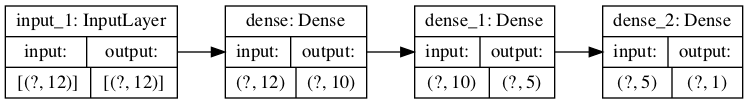

In [10]:
from tensorflow.keras.utils import plot_model

# you will need to install pydot properly on your machine to get this running
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [11]:
%%time

model.fit(X_train, y_train, epochs=10, batch_size=50, verbose=1)

# now lets see how well the model performed
from sklearn import metrics as mt
yhat_proba = model.predict(X_test)
yhat = np.round(yhat_proba)
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

Train on 30162 samples
Epoch 1/10
30162/30162 [==============================] - 1s 44us/sample - loss: 0.1947 - accuracy: 0.7353
Epoch 2/10
30162/30162 [==============================] - 1s 30us/sample - loss: 0.1880 - accuracy: 0.7478
Epoch 3/10
30162/30162 [==============================] - 1s 28us/sample - loss: 0.1875 - accuracy: 0.7500
Epoch 4/10
30162/30162 [==============================] - 1s 33us/sample - loss: 0.1873 - accuracy: 0.7505
Epoch 5/10
30162/30162 [==============================] - 1s 31us/sample - loss: 0.1872 - accuracy: 0.7508
Epoch 6/10
30162/30162 [==============================] - 1s 25us/sample - loss: 0.1871 - accuracy: 0.7509
Epoch 7/10
30162/30162 [==============================] - 1s 31us/sample - loss: 0.1871 - accuracy: 0.7509
Epoch 8/10
30162/30162 [==============================] - 1s 23us/sample - loss: 0.1870 - accuracy: 0.7510
Epoch 9/10
30162/30162 [==============================] - 1s 24us/sample - loss: 0.1870 - accuracy: 0.7510
Epoch 10/10
30

/Users/ericlarson/opt/anaconda3/envs/mlenv2021/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ouch! It didn't even train! **But we are not handling categorical data properly here...** Let's fix that.

## Embedding Categorical Data
In order to add one-hot encoding, we need to separate the categorical features that are currently saved as integers and place them into Embedding layers. An embedding layer deals with integers as if they were one-hot encoded. To start, let's only create a model from these categorical variables. 

- The first decision to make is about the size of the dense feature embeddings. This is essentially a dimensionality reduction step. 
 - This can be difficult to set, but one common setting is $\log_2(N)$ or $\sqrt{N}$ where $N$ is the total number of uniques values.
- When using an Embedding, we can leave the variables represented as integers. That is, keras will use the integer representation to figure out how to one-hot-encode the variable. This is great because it means we don't need to change the variable in memory.
- We will feed all the categorical variables to the model and, internally, the model will separate out the columns and apply a separate embedding. The function we will use to get each column is the `gather` function that is part of tensorflow.

In [12]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import concatenate
import tensorflow as tf

# start by getting only the categorical variables
# these matrices are all integers
X_train = df_train[categorical_headers_ints].to_numpy() 
X_test = df_test[categorical_headers_ints].to_numpy() 

embed_branches = []
all_branch_outputs = [] # this is where we will keep track of output of each branch

# feed in the entire matrix of categircal variables
input_branch = Input(shape=(X_train.shape[1],), 
                     dtype='int64', 
                     name='categorical')

# for each categorical variable
for idx,col in enumerate(categorical_headers_ints):
    
    # what the maximum integer value for this variable?
    # which is the same as the number of categories
    N = max(df_train[col].max(),df_test[col].max())+1 
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_branch, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs in list to concatenate later
    all_branch_outputs.append(x)
    
# now concatenate the outputs and add a fully connected layer
final_branch = concatenate(all_branch_outputs, name='concat_1')
final_branch = Dense(units=1,
                     activation='sigmoid', 
                     name='combined')(final_branch)

model = Model(inputs=input_branch, outputs=final_branch)

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
categorical (InputLayer)        [(None, 8)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_GatherV2 (TensorFlo [(None,)]            0           categorical[0][0]                
__________________________________________________________________________________________________
tf_op_layer_GatherV2_1 (TensorF [(None,)]            0           categorical[0][0]                
__________________________________________________________________________________________________
tf_op_layer_GatherV2_2 (TensorF [(None,)]            0           categorical[0][0]                
____________________________________________________________________________________________

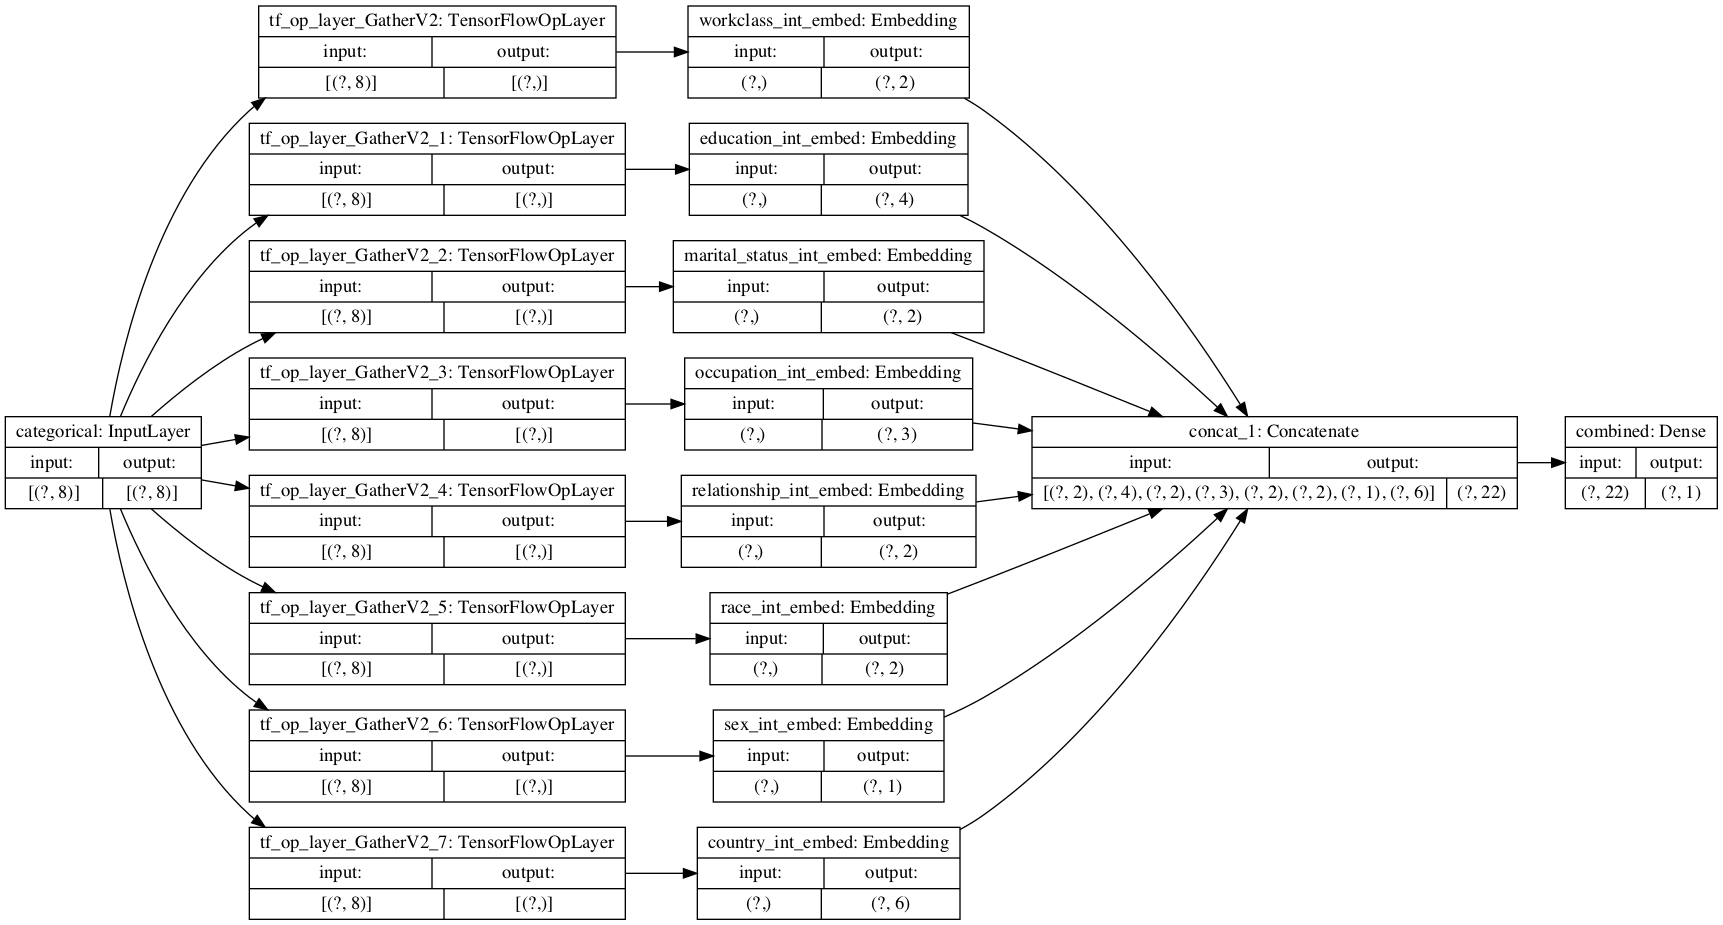

In [13]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [14]:
%%time

model.fit(X_train, y_train, epochs=10, batch_size=50, verbose=1)

from sklearn import metrics as mt
yhat_proba = model.predict(X_test)
yhat = np.round(yhat_proba)
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

Train on 30162 samples
Epoch 1/10
30162/30162 [==============================] - 2s 61us/sample - loss: 0.2041 - accuracy: 0.7501
Epoch 2/10
30162/30162 [==============================] - 1s 40us/sample - loss: 0.1789 - accuracy: 0.7511
Epoch 3/10
30162/30162 [==============================] - 1s 43us/sample - loss: 0.1704 - accuracy: 0.7511
Epoch 4/10
30162/30162 [==============================] - 1s 47us/sample - loss: 0.1633 - accuracy: 0.7511
Epoch 5/10
30162/30162 [==============================] - 1s 40us/sample - loss: 0.1573 - accuracy: 0.7519
Epoch 6/10
30162/30162 [==============================] - 1s 37us/sample - loss: 0.1527 - accuracy: 0.7534
Epoch 7/10
30162/30162 [==============================] - 1s 36us/sample - loss: 0.1494 - accuracy: 0.7654
Epoch 8/10
30162/30162 [==============================] - 1s 37us/sample - loss: 0.1470 - accuracy: 0.7710
Epoch 9/10
30162/30162 [==============================] - 1s 41us/sample - loss: 0.1451 - accuracy: 0.7783
Epoch 10/10
30

Much better!! Looks like the use of Embedding layers helped. Lets add some more of the features, using both the categorical and the integer features.

## Multi-Modal Networks: Combine Branches, Sparse and Dense
The keras functional API allows us to setup different branches of inputs. When we call the `fit` function, we can tell keras the input to each branch using a simple list (you can also use a dictionary to be more explicit).

- Lets create two matrices: 
 - one with the categorical data, `X_train_cat`
 - and another with the numeric data, `X_train_num`
 
Now, we can feed both of these into the model as a list and concatenate their results. 

In [15]:
# save categorical features
X_train_cat = df_train[categorical_headers_ints].to_numpy() 
X_test_cat = df_test[categorical_headers_ints].to_numpy() 

# and save off the numeric features
X_train_num =  df_train[numeric_headers].to_numpy()
X_test_num = df_test[numeric_headers].to_numpy()

all_branch_outputs = [] # this is where we will keep track of output of each branch

input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical')
for idx,col in enumerate(categorical_headers_ints):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(df_train[col].max(),df_test[col].max())+1
    
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_branch_outputs.append(x)
    
# HERE IS THE ADDING OF AN INPUT USING NUMERIC DATA
# create dense input branch for numeric
inputs_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=22, activation='relu', name='num_1')(inputs_num)
    
all_branch_outputs.append(x_dense)

# now concatenate the outputs and add a fully connected layer
final_branch = concatenate(all_branch_outputs, name='concat_1')
final_branch = Dense(units=10, activation='relu', name='combined_1')(final_branch)
final_branch = Dense(units=1, activation='sigmoid', name='combined_2')(final_branch)

model = Model(inputs=[input_cat,inputs_num], outputs=final_branch)

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
categorical (InputLayer)        [(None, 8)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_GatherV2_8 (TensorF [(None,)]            0           categorical[0][0]                
__________________________________________________________________________________________________
tf_op_layer_GatherV2_9 (TensorF [(None,)]            0           categorical[0][0]                
__________________________________________________________________________________________________
tf_op_layer_GatherV2_10 (Tensor [(None,)]            0           categorical[0][0]                
____________________________________________________________________________________________

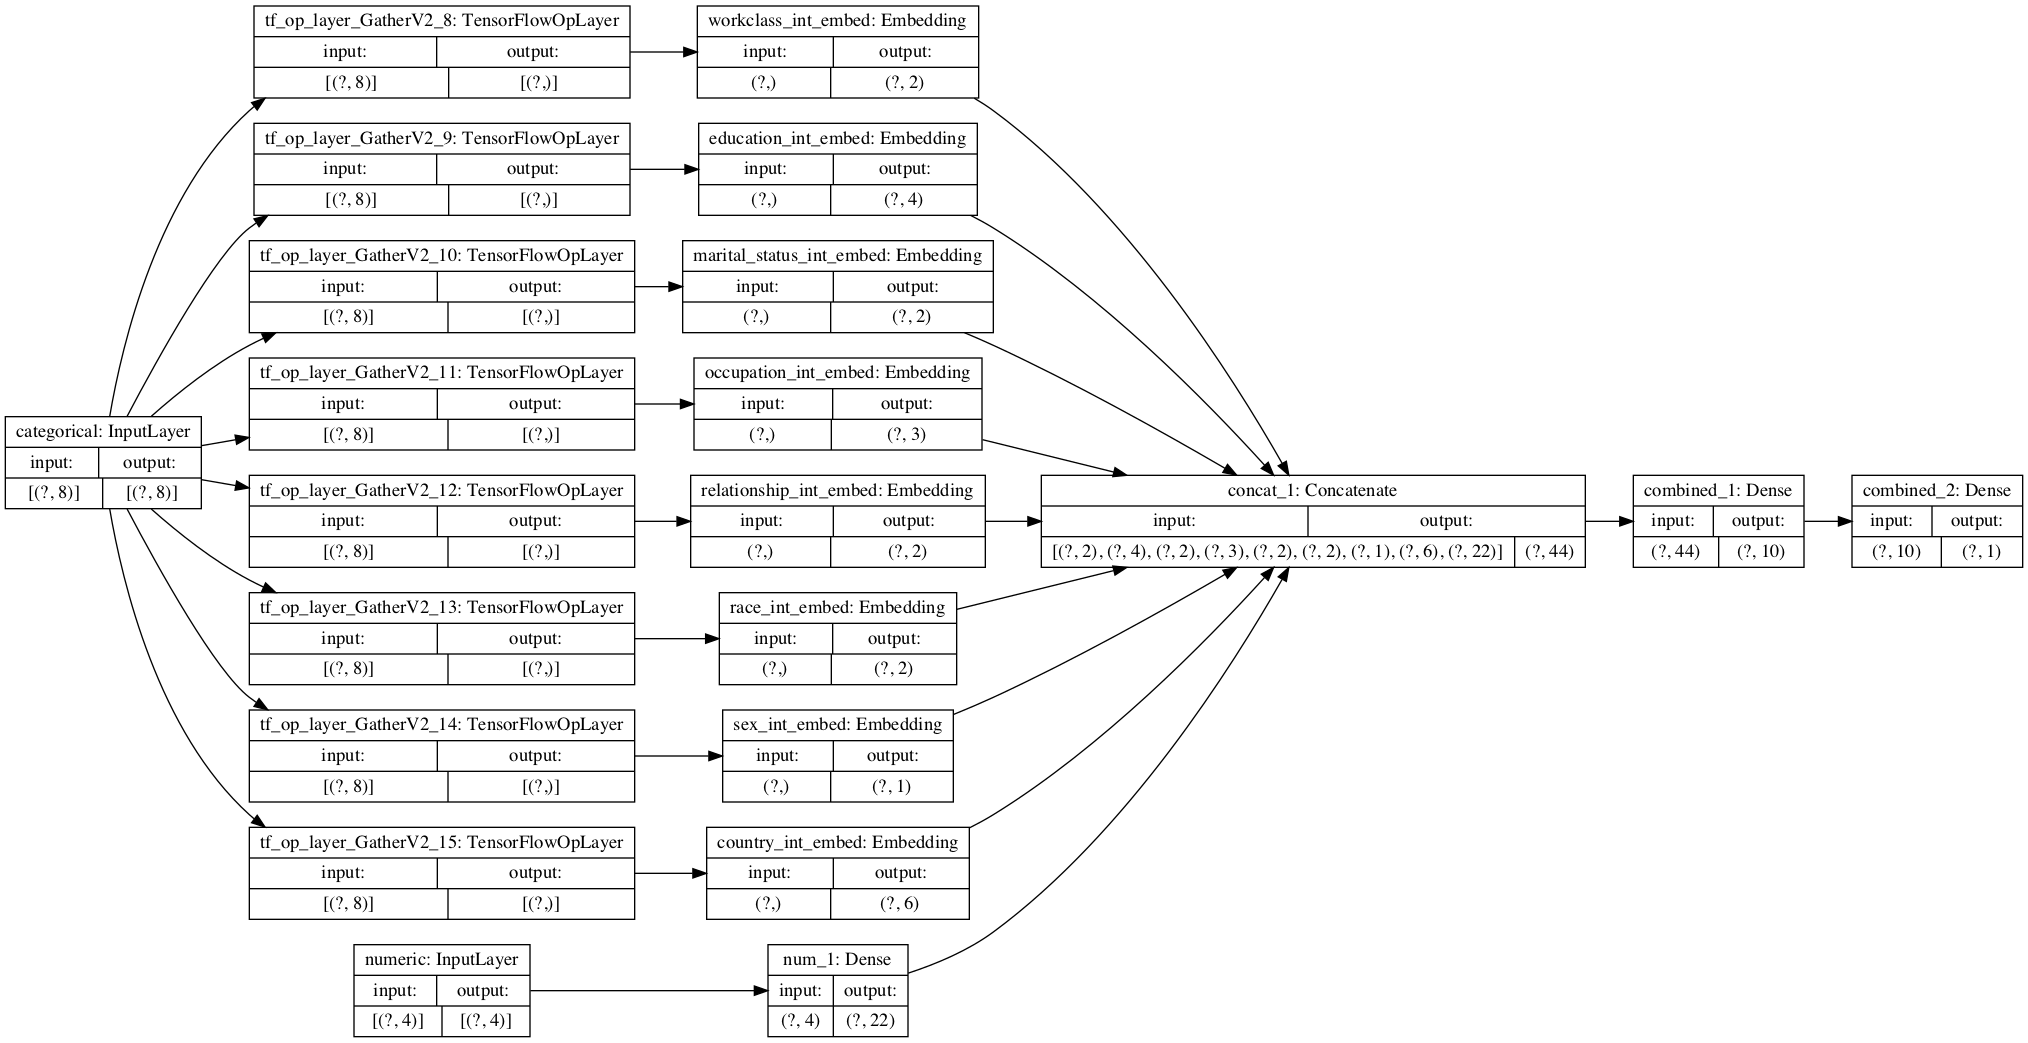

In [16]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [17]:
%%time

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit([ X_train_cat, X_train_num ], # inputs for each branch are a list
          y_train, 
          epochs=10, 
          batch_size=50, 
          verbose=1)

yhat = model.predict([X_test_cat,
                      X_test_num]) # each branch has an input

yhat = np.round(yhat)
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

Train on 30162 samples
Epoch 1/10
30162/30162 [==============================] - 2s 73us/sample - loss: 0.2225 - accuracy: 0.6609
Epoch 2/10
30162/30162 [==============================] - 1s 45us/sample - loss: 0.1758 - accuracy: 0.7569
Epoch 3/10
30162/30162 [==============================] - 2s 50us/sample - loss: 0.1660 - accuracy: 0.7614
Epoch 4/10
30162/30162 [==============================] - 2s 54us/sample - loss: 0.1597 - accuracy: 0.7662
Epoch 5/10
30162/30162 [==============================] - 2s 53us/sample - loss: 0.1541 - accuracy: 0.7721
Epoch 6/10
30162/30162 [==============================] - 2s 56us/sample - loss: 0.1486 - accuracy: 0.7786
Epoch 7/10
30162/30162 [==============================] - 2s 54us/sample - loss: 0.1430 - accuracy: 0.7868
Epoch 8/10
30162/30162 [==============================] - 2s 54us/sample - loss: 0.1374 - accuracy: 0.7965
Epoch 9/10
30162/30162 [==============================] - 1s 44us/sample - loss: 0.1323 - accuracy: 0.8021
Epoch 10/10
30

So the confusion matrix is doing better! But we still are just using a simple neural network. We really want to take advantage of the embeddings and crossed columns that are possible with tensorflow. 


**[Back to Slides]**
___

# Crossed Columns and Deep Embeddings
Lets create the network below in steps. This network consists of a number of different paths for the input data to take.
![asdfasfd](https://www.tensorflow.org/images/wide_n_deep.svg)

 


___


## Making Crossed Columns
For this example, we are going to make embeddings for crossed columns. We will perform this step using `sklearn` 

Let's start simple with 
- branches of crossed categorical features as input 
- one branch for each crossed column

In [19]:
# sandbox for looking at different categorical variables
for col in categorical_headers:
    vals = df_train[col].unique()
    print(col,'has', len(vals), 'unique values:')
    print(vals)

workclass has 7 unique values:
['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov'
 'Self-emp-inc' 'Without-pay']
education has 16 unique values:
['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 '7th-8th' 'Doctorate' 'Assoc-voc' 'Prof-school' '5th-6th' '10th'
 'Preschool' '12th' '1st-4th']
marital_status has 7 unique values:
['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']
occupation has 14 unique values:
['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Transport-moving' 'Farming-fishing'
 'Machine-op-inspct' 'Tech-support' 'Craft-repair' 'Protective-serv'
 'Armed-Forces' 'Priv-house-serv']
relationship has 6 unique values:
['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative']
race has 5 unique values:
['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']
sex has 2 unique values:
['Male' 'Female

In [20]:
# possible crossing options:
#   'workclass','education','marital_status',
#   'occupation','relationship','race',
#   'sex','country'

cross_columns = [['race','sex','education','occupation'],
                 #['sex', 'marital_status'],
                 #['workclass','occupation'],
                 #['occupation','race','education'],
                 ['education','country']
                ]

# cross each set of columns in the list above
cross_col_df_names = []
for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()
    
    # 1. create crossed labels by join operation
    X_crossed_train = df_train[cols_list].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = df_test[cols_list].apply(lambda x: '_'.join(x), axis=1)
    
    # get a nice name for this new crossed column
    cross_col_name = '_'.join(cols_list)
    
    # 2. encode as integers
    enc.fit(np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy())))
    
    # 3. Save into dataframe with new name
    df_train[cross_col_name] = enc.transform(X_crossed_train)
    df_test[cross_col_name] = enc.transform(X_crossed_test)
    
    # keep track of the new names of the crossed columns
    cross_col_df_names.append(cross_col_name) 
    
cross_col_df_names

['race_sex_education_occupation', 'education_country']

In [21]:
# get crossed columns
X_train_crossed = df_train[cross_col_df_names].to_numpy()
X_test_crossed = df_test[cross_col_df_names].to_numpy()

crossed_outputs = [] # this is where we will keep track of output of each branch

input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='categorical')
for idx,col in enumerate(cross_col_df_names):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(df_train[col].max(),df_test[col].max())+1
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
wide_branch = concatenate(crossed_outputs, name='concat_1')
wide_branch = Dense(units=1,activation='sigmoid', name='combined')(wide_branch)

model = Model(inputs=input_crossed, outputs=wide_branch)

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit(X_train_crossed,
        y_train, epochs=10, batch_size=32, verbose=1)

Train on 30162 samples
Epoch 1/10
30162/30162 [==============================] - 3s 84us/sample - loss: 0.2060 - accuracy: 0.7470
Epoch 2/10
30162/30162 [==============================] - 2s 71us/sample - loss: 0.1834 - accuracy: 0.7511
Epoch 3/10
30162/30162 [==============================] - 2s 61us/sample - loss: 0.1792 - accuracy: 0.7511
Epoch 4/10
30162/30162 [==============================] - 2s 61us/sample - loss: 0.1769 - accuracy: 0.7511
Epoch 5/10
30162/30162 [==============================] - 2s 75us/sample - loss: 0.1749 - accuracy: 0.7511
Epoch 6/10
30162/30162 [==============================] - 2s 71us/sample - loss: 0.1731 - accuracy: 0.7511
Epoch 7/10
30162/30162 [==============================] - 2s 70us/sample - loss: 0.1716 - accuracy: 0.7511
Epoch 8/10
30162/30162 [==============================] - 2s 76us/sample - loss: 0.1701 - accuracy: 0.7511
Epoch 9/10
30162/30162 [==============================] - 2s 76us/sample - loss: 0.1688 - accuracy: 0.7511
Epoch 10/10
30

In [22]:
model.fit(X_train_crossed,
        y_train, epochs=10, batch_size=32, verbose=1)

Train on 30162 samples
Epoch 1/10
30162/30162 [==============================] - 2s 74us/sample - loss: 0.1664 - accuracy: 0.7699
Epoch 2/10
30162/30162 [==============================] - 2s 62us/sample - loss: 0.1653 - accuracy: 0.7719
Epoch 3/10
30162/30162 [==============================] - 2s 68us/sample - loss: 0.1642 - accuracy: 0.7782
Epoch 4/10
30162/30162 [==============================] - 2s 69us/sample - loss: 0.1632 - accuracy: 0.7799
Epoch 5/10
30162/30162 [==============================] - 2s 66us/sample - loss: 0.1622 - accuracy: 0.7805
Epoch 6/10
30162/30162 [==============================] - 2s 61us/sample - loss: 0.1613 - accuracy: 0.7805
Epoch 7/10
30162/30162 [==============================] - 2s 67us/sample - loss: 0.1604 - accuracy: 0.7805
Epoch 8/10
30162/30162 [==============================] - 2s 65us/sample - loss: 0.1596 - accuracy: 0.7827
Epoch 9/10
30162/30162 [==============================] - 2s 70us/sample - loss: 0.1588 - accuracy: 0.7844
Epoch 10/10
30

In [23]:
yhat = np.round(model.predict(X_test_crossed))
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

[[10934   426]
 [ 2893   807]]
              precision    recall  f1-score   support

           0       0.79      0.96      0.87     11360
           1       0.65      0.22      0.33      3700

    accuracy                           0.78     15060
   macro avg       0.72      0.59      0.60     15060
weighted avg       0.76      0.78      0.74     15060



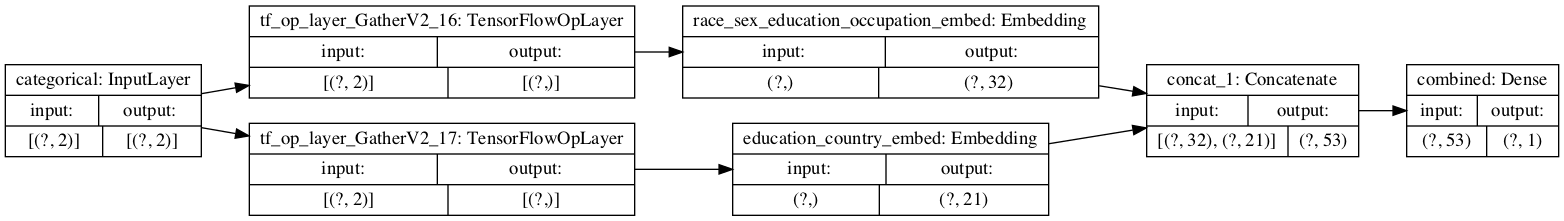

In [24]:
# you will need to install pydot properly on your machine to get this running
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

Wow! That is just using crossed columns and a one layer Linear Classifer! So memorization works fairly well here.


___


## Combining Crossed Linear Classifier and Deep Embeddings
Now its just a matter of setting the wide and deep columns for tensorflow. After which, we can use the combined classifier!

Wide and deep models can have really interesting and useful properties so they are great to keep in mind when selecting an architecture. Some of the hyperparameters that are specific to this are:
- which features to cross together, typically you only want to cross columns you think are important to be connected--they somehow might create new knowledge by combining.
- the size of the dense feature embeddings. This can be difficult to set, but one common setting is $log_2(N)$ or $\sqrt{N}$ where $N$ is the total number of uniques values.

In [25]:
# get crossed columns
X_train_crossed = df_train[cross_col_df_names].to_numpy()
X_test_crossed = df_test[cross_col_df_names].to_numpy()

# save categorical features
X_train_cat = df_train[categorical_headers_ints].to_numpy() 
X_test_cat = df_test[categorical_headers_ints].to_numpy() 

# and save off the numeric features
X_train_num =  df_train[numeric_headers].to_numpy()
X_test_num = df_test[numeric_headers].to_numpy()


# we need to create separate lists for each branch
crossed_outputs = []

# CROSSED DATA INPUT
input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(df_train[col].max(),df_test[col].max())+1
    
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
wide_branch = concatenate(crossed_outputs, name='wide_concat')

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_headers_ints):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(df_train[col].max(),df_test[col].max())+1
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)
    
# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)
    
all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    
# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

model = Model(inputs=[input_crossed,input_cat,input_num], 
              outputs=final_branch)



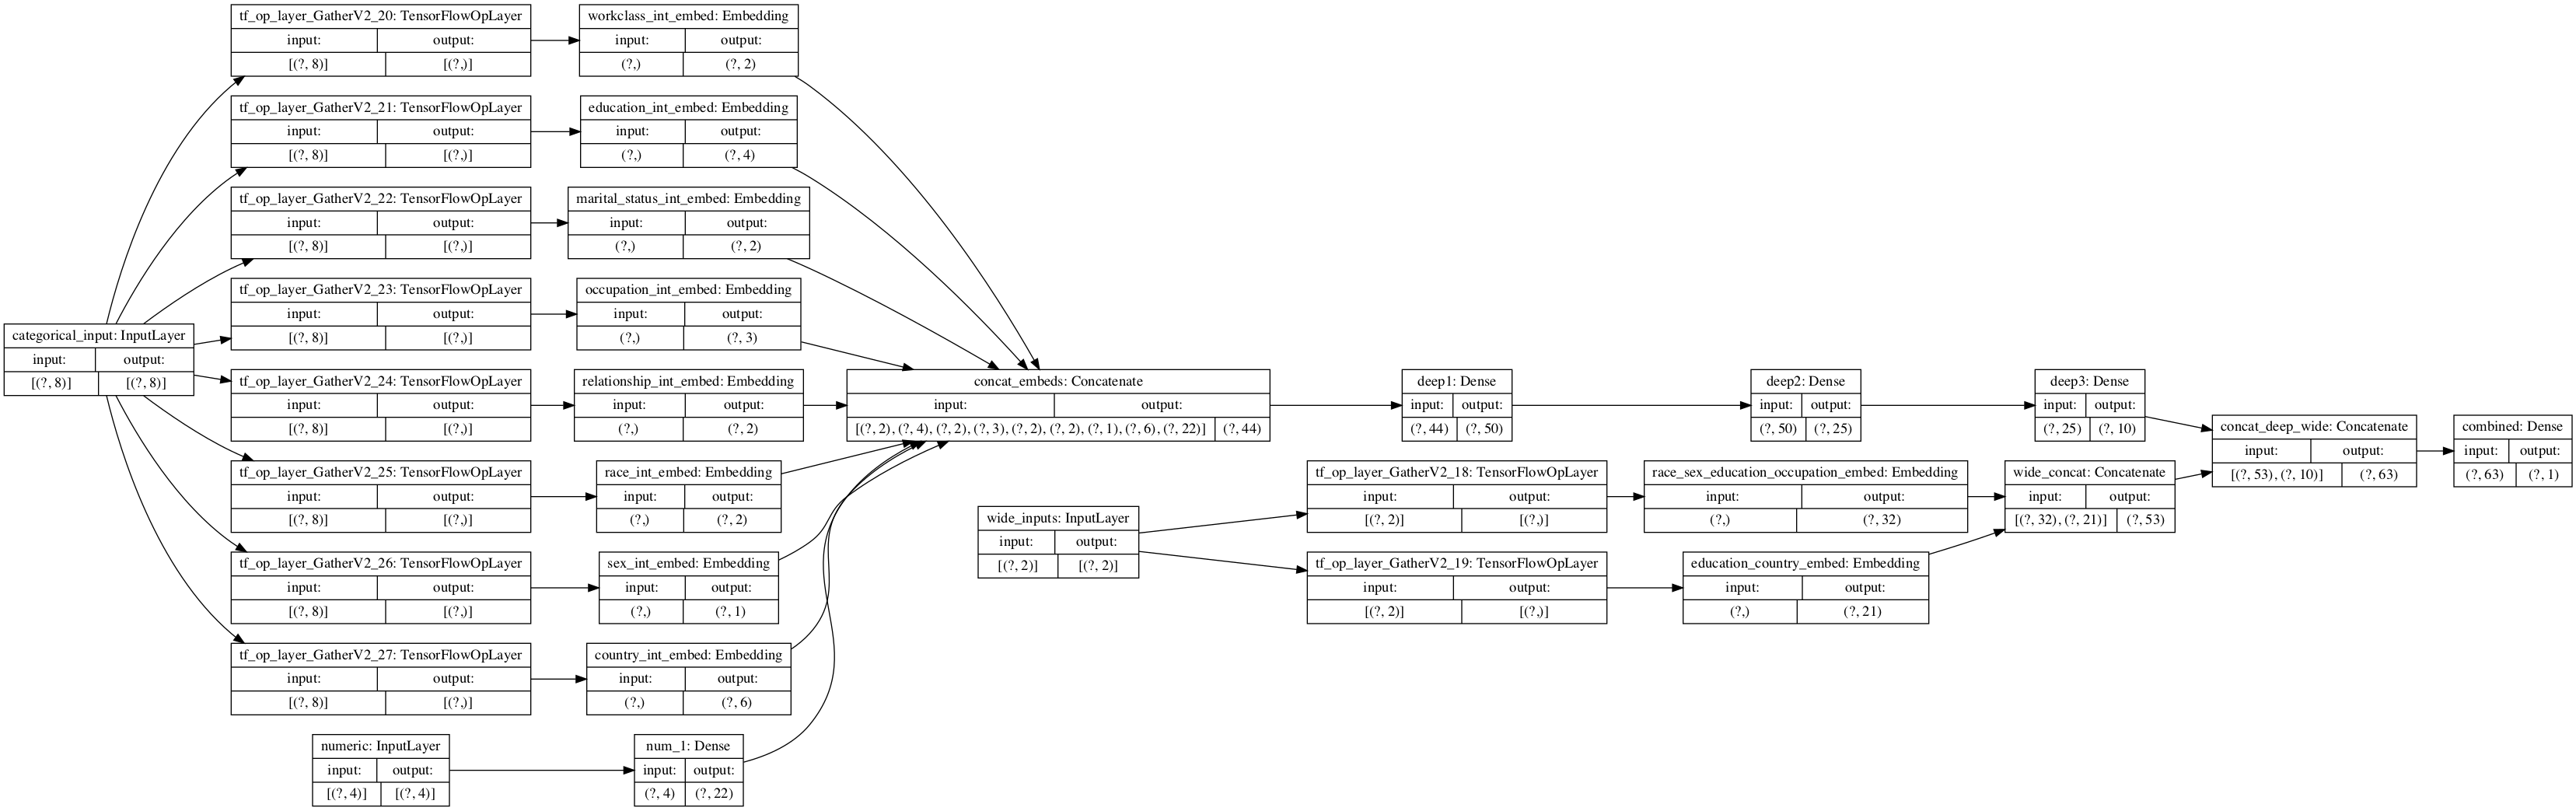

In [27]:
# you will need to install pydot properly on your machine to get this running
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)
# model.summary()

In [28]:
%%time

model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['accuracy'])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history = model.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train, 
                    epochs=15, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))

Train on 30162 samples, validate on 15060 samples
Epoch 1/15
30162/30162 [==============================] - 8s 249us/sample - loss: 0.1755 - accuracy: 0.7643 - val_loss: 0.1492 - val_accuracy: 0.7807
Epoch 2/15
30162/30162 [==============================] - 5s 172us/sample - loss: 0.1407 - accuracy: 0.7923 - val_loss: 0.1341 - val_accuracy: 0.8066
Epoch 3/15
30162/30162 [==============================] - 6s 187us/sample - loss: 0.1289 - accuracy: 0.8151 - val_loss: 0.1252 - val_accuracy: 0.8243
Epoch 4/15
30162/30162 [==============================] - 5s 180us/sample - loss: 0.1216 - accuracy: 0.8310 - val_loss: 0.1195 - val_accuracy: 0.8337
Epoch 5/15
30162/30162 [==============================] - 5s 167us/sample - loss: 0.1169 - accuracy: 0.8394 - val_loss: 0.1157 - val_accuracy: 0.8386
Epoch 6/15
30162/30162 [==============================] - 5s 171us/sample - loss: 0.1138 - accuracy: 0.8417 - val_loss: 0.1131 - val_accuracy: 0.8417
Epoch 7/15
30162/30162 [==========================

In [29]:
yhat = np.round(model.predict([X_test_crossed,X_test_cat,X_test_num]))
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

[[10660   700]
 [ 1547  2153]]
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     11360
           1       0.75      0.58      0.66      3700

    accuracy                           0.85     15060
   macro avg       0.81      0.76      0.78     15060
weighted avg       0.84      0.85      0.84     15060



Text(0.5, 0, 'epochs')

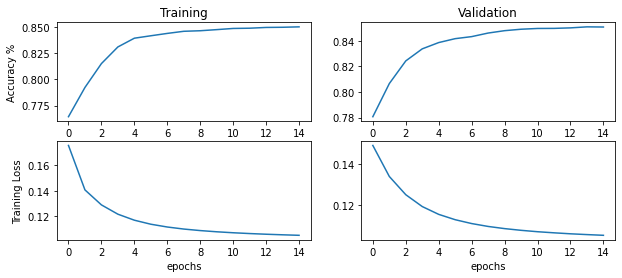

In [30]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

# Making Generalization Better
In what ways might we try to make the model found generalize more concretely?

**Self Test:** What is the best method to make the results better?  
- A. Add Dropout to deep network
- B. Add Dropout to wide network
- C. Perturb the Categorical Data during Training (augmentation)
- D. Add L2 regularization to different layer's weights